In [1]:
import gym
import numpy as np
import pandas as pd
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import envs.TradingEnv

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [3]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=8, 
                 action_size=3, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
    
    def length(self):
        return len(self.buffer)

In [28]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 365                # max steps in an episode
gamma = 0.99                   # future reward discount

action_size = 3

# Exploration parameters
explore_start = 0.1            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 8               # number of units in each Q-network hidden layer
learning_rate = 0.00001         # Q-network learning rate

# Memory parameters
memory_size = 200000            # memory capacity
batch_size = 258                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

transaction_cost_ratio = 0.0

In [6]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)
env = envs.TradingEnv.FxEnv(scenario_length=max_steps, transaction_cost_ratio=transaction_cost_ratio)
env.seed(1234)
np.random.seed(1234)

In [7]:
def make_state(observation, means, stds):
    return np.array([observation[0], observation[1], observation[2],
                    (observation[3]-means[3])/stds[3],
                    (observation[4]-means[4])/stds[4],
                    (observation[5]-means[5])/stds[5],
                    (observation[6]-means[6])/stds[6],
                    (observation[7]-means[7])/stds[7]])

In [8]:
"""
env.reset()
values = []
for i in range(100000):
    observation, reward, done = env.step(env.action_space.sample())
    values.append(observation)
    if done:
        env.reset()

values_array = np.array(values)
means = values_array.mean(axis=0)
stds = values_array.std(axis=0)
print(means)
print(stds)
"""
means = [0.332350000, 0.334510000, 0.333140000, 0.000368700000, 0.000294200000, 0.546393900, 0.562338400, 0.493165397]
stds = [0.47105571, 0.47181888, 0.47133612, 0.67677779, 0.97742333, 0.97325276, 0.95412702, 0.28551883]

In [26]:
memory = Memory(max_size=memory_size)
env.reset()
observation, reward, done = env.step(env.action_space.sample())
state = make_state(observation, means, stds)
for i in range(20000):
    memory.add((state))
    observation, reward, done = env.step(env.action_space.sample())
    state = make_state(observation, means, stds)
    if done:
        env.reset()

KeyboardInterrupt: 

In [9]:
[val[0:3] for val in memory.sample(3)]

NameError: name 'memory' is not defined

In [27]:
opt = optim.Adam(mainQN.parameters(), 0.00001)
i = 0
while(True):
    batch = memory.sample(512)
    batch_state = np.array(batch)
    batch_q = torch.FloatTensor(np.array([val[0:3] for val in batch]))
    
    current_q_values = mainQN(Variable(torch.FloatTensor(batch_state)))
    loss = torch.nn.MSELoss()(current_q_values, batch_q)
    # backpropagation of loss to NN
    # 勾配を初期化
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i % 100 == 0:
        print(loss.data.numpy())
    
    if loss.data.numpy() < 0.0001:
        break
        
    i += 1
torch.save(mainQN.state_dict(), 'KeepPolicy.pth')

0.45329916
0.44351408
0.4524858
0.44287172
0.43894967
0.43980053
0.44616437
0.42724034
0.42224783
0.42525277
0.42040077
0.4102428
0.4147234
0.41300148
0.41278923
0.4100938
0.39350542
0.39896485
0.38395402
0.37952358
0.3797274
0.37142873
0.37497583


KeyboardInterrupt: 

In [22]:
mainQN.load_state_dict(torch.load('KeepPolicy.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
def optimize(memory, opt, batch_size):
    # Sample mini-batch from memory
    batch = memory.sample(batch_size)
    #memory.buffer.clear()
    states = np.array([each[0] for each in batch])
    ### ポイント！！！
    # actionはスカラーなのでベクトルにする
    # actionsはベクトルでなく、statesと同じ行列
    actions = np.array([[each[1]] for each in batch])
    ### ポイント終わり
    rewards = np.array([each[2] for each in batch])
    next_states = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])

    # Train network
    non_final_mask = torch.tensor(tuple(map(lambda s: s==False, dones)), dtype=torch.uint8)
    # 終端状態のQ値はその後の報酬が存在しないためゼロとする
    target_maxQs = torch.zeros(batch_size)
    target_maxQs[non_final_mask] = mainQN(Variable(torch.FloatTensor(next_states)[non_final_mask])).max(1)[0].detach()

    #tutorial way
    targets = (torch.FloatTensor(rewards) + gamma * target_maxQs).unsqueeze(1)

    for i in range(1):
        current_q_values = mainQN(Variable(torch.FloatTensor(states))).gather(1, torch.LongTensor(actions))
        loss = torch.nn.SmoothL1Loss()(current_q_values, targets)
        # backpropagation of loss to NN
        # 勾配を初期化
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss

In [24]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
observation, reward, done, _ = env.step(env.action_space.sample())
state = make_state(observation, means, stds)
last_action = 0
current_position_reward = 0
memory = Memory(max_size=memory_size)
t = 0
keep_list = []

# Make a bunch of random actions and store the experiences
while(len(memory.buffer)<batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    if 0.1 > np.random.rand():
        # Make a random action
        action = env.action_space.sample()
    else:
        action = last_action
    next_observation, reward, done, _ = env.step(action)
    next_state = make_state(next_observation, means, stds)
    
    current_position_reward += reward
    
    if last_action != action:
        if last_action != 0:
            clipped_reward = current_position_reward/(t-entry_t)
            memory.add((entry_state, last_action, clipped_reward, next_state, done))
            if current_position_reward > 0:
                for val in keep_list:
                    memory.add((val[0], val[1], clipped_reward, val[2], done))
            keep_list = []
            

        entry_state = state
        entry_t = t
        current_position_reward = 0.0
    else:
        keep_list.append([state, action, next_state])

    last_action = action
    state = next_state
    t += 1

    if done:
        # Start new episode
        env.reset()
        last_action = 0
        current_position_reward = 0.0
        t = 0
        entry_t = 0
        observation, reward, done, _ = env.step(env.action_space.sample())
        state = make_state(observation, means, stds)

In [30]:
rewards_list = []
opt = optim.Adam(mainQN.parameters(), learning_rate)

outputs = np.empty([1,11])
episode_reward_deque = deque(maxlen=100)

count_stop = 0
for ep in range(10000, train_episodes+1000):
    total_reward = 0
    current_position_reward = 0
    last_action = 0
    initial_action = 0
    t = 0
    # Start new episode
    observation = env.reset()
    state = make_state(observation, means, stds)
    max_point = info
    min_point = info
            
    for t in range(max_steps):
        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*(ep*max_steps+t))
        if ep > train_episodes:
            explore_p = 0.0
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(Variable(torch.FloatTensor(state))).data.numpy()
            action = np.argmax(Qs)
            
        result = np.hstack((state, mainQN(Variable(torch.FloatTensor(state))).data.numpy()))
        outputs = np.vstack((outputs, result))

        # Take action, get new state and reward
        next_observation, reward, done, info = env.step(action)
        next_state = make_state(next_observation, means, stds)

        total_reward += reward
        current_position_reward += reward
        
        if last_action != action or done:
            if last_action != 0:
                clipped_reward = current_position_reward/(t-entry_t)
                memory.add((entry_state, last_action, clipped_reward, next_state, done))
                if current_position_reward > 0:
                    for val in keep_list:
                        memory.add((val[0], val[1], clipped_reward, val[2], done))
                else:
                    print(mainQN(Variable(torch.FloatTensor(entry_state))).data.numpy())
                    print('entry_state_action={}, initial_action={}, action={}, position reward={:.4f}'.format(np.argmax(entry_state[0:3]), initial_action, last_action, current_position_reward))
                    print('entry_point={:.4f} exit_point={:.4f} max_point={:.4f} min_point={:.4f}'.format(entry_point, info, max_point, min_point))
                keep_list = [] 
                loss = optimize(memory, opt, batch_size)
                
            entry_state = state
            initial_action = last_action
            entry_t = t
            current_position_reward = 0.0
            max_point = info
            min_point = info
            entry_point = info
        else:
            keep_list.append([state, action, next_state])
            max_point = info if info > max_point else max_point
            min_point = info if info < min_point else min_point
            
        last_action = action
        state = next_state

        
        
        if done:
            episode_reward_deque.append(total_reward)
            # the episode ends so no next state
            print('Episode: {}'.format(ep),
                  'Total reward: {:.4f}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss.data.numpy()),
                  'Explore P: {:.4f}'.format(explore_p),
                  'Reward mean: {:.4f}'.format(np.array(list(episode_reward_deque)).mean()),
                  'Reward std: {:.4f}'.format(np.array(list(episode_reward_deque)).std()))
            rewards_list.append((ep, total_reward))
            break
df = pd.DataFrame(outputs)
df.to_csv('result.csv')

[ 0.4052346  -0.09494403 -0.25772655]
entry_state_action=0, initial_action=0, action=2, position reward=-15.0600
entry_point=101.9800 exit_point=117.4700 max_point=121.6000 min_point=101.2600
[ 0.51191914 -0.12909076 -0.210711  ]
entry_state_action=0, initial_action=0, action=2, position reward=-4.4300
entry_point=120.1600 exit_point=123.8900 max_point=125.5000 min_point=119.2700
Episode: 10000 Total reward: -18.7400 Training loss: 0.0390 Explore P: 0.0100 Reward mean: -18.7400 Reward std: 0.0000
Episode: 10001 Total reward: 0.0000 Training loss: 0.0390 Explore P: 0.0000 Reward mean: -9.3700 Reward std: 9.3700
Episode: 10002 Total reward: -0.8700 Training loss: 0.0420 Explore P: 0.0000 Reward mean: -6.5367 Reward std: 8.6364
Episode: 10003 Total reward: 7.0700 Training loss: 0.0358 Explore P: 0.0000 Reward mean: -3.1350 Reward std: 9.5212
Episode: 10004 Total reward: 0.0000 Training loss: 0.0358 Explore P: 0.0000 Reward mean: -2.5080 Reward std: 8.6079
[-0.1379241   0.06213009 -0.45608

Episode: 10052 Total reward: 0.0000 Training loss: 0.0367 Explore P: 0.0000 Reward mean: -1.5592 Reward std: 4.8515
Episode: 10053 Total reward: 0.0000 Training loss: 0.0367 Explore P: 0.0000 Reward mean: -1.5304 Reward std: 4.8110
Episode: 10054 Total reward: 0.0000 Training loss: 0.0367 Explore P: 0.0000 Reward mean: -1.5025 Reward std: 4.7714
[-0.06073965  0.12857687 -0.48044467]
entry_state_action=0, initial_action=0, action=1, position reward=-19.4200
entry_point=109.3000 exit_point=91.4100 max_point=110.2800 min_point=87.4700
Episode: 10055 Total reward: -19.8100 Training loss: 0.0375 Explore P: 0.0000 Reward mean: -1.8295 Reward std: 5.3139
[-0.1427401   0.03929749 -0.4433241 ]
entry_state_action=0, initial_action=0, action=1, position reward=-3.4800
entry_point=106.4600 exit_point=103.2800 max_point=110.9400 min_point=99.8100
Episode: 10056 Total reward: -2.5500 Training loss: 0.0359 Explore P: 0.0000 Reward mean: -1.8421 Reward std: 5.2680
Episode: 10057 Total reward: 0.0000 T

Episode: 10112 Total reward: 0.0000 Training loss: 0.0361 Explore P: 0.0000 Reward mean: -1.0691 Reward std: 4.5522
Episode: 10113 Total reward: 0.0000 Training loss: 0.0361 Explore P: 0.0000 Reward mean: -1.1152 Reward std: 4.5176
Episode: 10114 Total reward: 0.0000 Training loss: 0.0361 Explore P: 0.0000 Reward mean: -1.1152 Reward std: 4.5176
Episode: 10115 Total reward: 0.0000 Training loss: 0.0361 Explore P: 0.0000 Reward mean: -1.1152 Reward std: 4.5176
Episode: 10116 Total reward: 0.0000 Training loss: 0.0361 Explore P: 0.0000 Reward mean: -0.9351 Reward std: 4.1875
Episode: 10117 Total reward: 6.4100 Training loss: 0.0376 Explore P: 0.0000 Reward mean: -0.8710 Reward std: 4.2499
Episode: 10118 Total reward: 0.0000 Training loss: 0.0376 Explore P: 0.0000 Reward mean: -0.8261 Reward std: 4.2351
Episode: 10119 Total reward: 0.0000 Training loss: 0.0376 Explore P: 0.0000 Reward mean: -0.8261 Reward std: 4.2351
Episode: 10120 Total reward: 0.0000 Training loss: 0.0376 Explore P: 0.0

Episode: 10172 Total reward: 0.0000 Training loss: 0.0297 Explore P: 0.0000 Reward mean: -0.4574 Reward std: 2.8087
Episode: 10173 Total reward: 0.0000 Training loss: 0.0297 Explore P: 0.0000 Reward mean: -0.4574 Reward std: 2.8087
Episode: 10174 Total reward: 3.7800 Training loss: 0.0430 Explore P: 0.0000 Reward mean: -0.4196 Reward std: 2.8399
Episode: 10175 Total reward: 0.0000 Training loss: 0.0430 Explore P: 0.0000 Reward mean: -0.3023 Reward std: 2.6026
[ 0.00759627  0.19804716 -0.42731595]
entry_state_action=0, initial_action=0, action=1, position reward=-2.4000
entry_point=94.2800 exit_point=90.3700 max_point=100.7800 min_point=86.3100
Episode: 10176 Total reward: -3.3700 Training loss: 0.0444 Explore P: 0.0000 Reward mean: -0.3360 Reward std: 2.6203
Episode: 10177 Total reward: 0.0000 Training loss: 0.0444 Explore P: 0.0000 Reward mean: -0.3360 Reward std: 2.6203
Episode: 10178 Total reward: 0.0000 Training loss: 0.0444 Explore P: 0.0000 Reward mean: -0.3360 Reward std: 2.6203

Episode: 10227 Total reward: 0.0000 Training loss: 0.0388 Explore P: 0.0000 Reward mean: -0.8280 Reward std: 2.8794
Episode: 10228 Total reward: 0.0000 Training loss: 0.0388 Explore P: 0.0000 Reward mean: -0.8280 Reward std: 2.8794
Episode: 10229 Total reward: 0.0000 Training loss: 0.0388 Explore P: 0.0000 Reward mean: -0.8280 Reward std: 2.8794
Episode: 10230 Total reward: 0.0000 Training loss: 0.0388 Explore P: 0.0000 Reward mean: -0.8280 Reward std: 2.8794
Episode: 10231 Total reward: 0.0000 Training loss: 0.0388 Explore P: 0.0000 Reward mean: -0.8280 Reward std: 2.8794
Episode: 10232 Total reward: 5.1900 Training loss: 0.0487 Explore P: 0.0000 Reward mean: -0.7761 Reward std: 2.9400
Episode: 10233 Total reward: 0.0000 Training loss: 0.0487 Explore P: 0.0000 Reward mean: -0.7761 Reward std: 2.9400
Episode: 10234 Total reward: 0.0000 Training loss: 0.0487 Explore P: 0.0000 Reward mean: -0.7761 Reward std: 2.9400
Episode: 10235 Total reward: 0.0000 Training loss: 0.0487 Explore P: 0.0

Episode: 10283 Total reward: 0.0000 Training loss: 0.0538 Explore P: 0.0000 Reward mean: -0.8379 Reward std: 3.9567
Episode: 10284 Total reward: 0.0000 Training loss: 0.0538 Explore P: 0.0000 Reward mean: -0.6946 Reward std: 3.7177
[-0.14884177  0.05212718 -0.45530844]
entry_state_action=0, initial_action=0, action=1, position reward=-3.2200
entry_point=106.4600 exit_point=104.4900 max_point=110.9400 min_point=99.8100
Episode: 10285 Total reward: -2.2900 Training loss: 0.0447 Explore P: 0.0000 Reward mean: -0.7175 Reward std: 3.7204
Episode: 10286 Total reward: 0.0000 Training loss: 0.0447 Explore P: 0.0000 Reward mean: -0.7175 Reward std: 3.7204
Episode: 10287 Total reward: 0.0000 Training loss: 0.0447 Explore P: 0.0000 Reward mean: -0.7175 Reward std: 3.7204
Episode: 10288 Total reward: 0.0000 Training loss: 0.0447 Explore P: 0.0000 Reward mean: -0.7175 Reward std: 3.7204
[-0.04749061  0.13186634 -0.4834011 ]
entry_state_action=0, initial_action=0, action=1, position reward=-11.1500


Episode: 10341 Total reward: 0.0000 Training loss: 0.0470 Explore P: 0.0000 Reward mean: -0.7862 Reward std: 4.0316
Episode: 10342 Total reward: 0.0000 Training loss: 0.0470 Explore P: 0.0000 Reward mean: -0.7862 Reward std: 4.0316
Episode: 10343 Total reward: 2.3600 Training loss: 0.0402 Explore P: 0.0000 Reward mean: -0.7138 Reward std: 4.0225
Episode: 10344 Total reward: 0.0000 Training loss: 0.0402 Explore P: 0.0000 Reward mean: -0.7138 Reward std: 4.0225
Episode: 10345 Total reward: 0.0000 Training loss: 0.0402 Explore P: 0.0000 Reward mean: -0.7138 Reward std: 4.0225
[-0.10107359  0.02257058 -0.4210138 ]
entry_state_action=0, initial_action=0, action=1, position reward=-0.7900
entry_point=109.3000 exit_point=107.9500 max_point=110.1300 min_point=105.9300
Episode: 10346 Total reward: -1.1800 Training loss: 0.0417 Explore P: 0.0000 Reward mean: -0.7958 Reward std: 3.9469
[ 0.01042206  0.20096195 -0.4287403 ]
entry_state_action=0, initial_action=0, action=1, position reward=-0.8600


Episode: 10402 Total reward: 0.0000 Training loss: 0.0412 Explore P: 0.0000 Reward mean: -0.2283 Reward std: 2.6236
Episode: 10403 Total reward: 0.0000 Training loss: 0.0412 Explore P: 0.0000 Reward mean: -0.2283 Reward std: 2.6236
Episode: 10404 Total reward: 0.0000 Training loss: 0.0412 Explore P: 0.0000 Reward mean: -0.2283 Reward std: 2.6236
Episode: 10405 Total reward: 0.0000 Training loss: 0.0412 Explore P: 0.0000 Reward mean: -0.2283 Reward std: 2.6236
[-0.10403353  0.01715919 -0.41843358]
entry_state_action=0, initial_action=0, action=1, position reward=-2.4500
entry_point=109.3000 exit_point=106.6600 max_point=110.1300 min_point=105.9300
Episode: 10406 Total reward: -2.8400 Training loss: 0.0493 Explore P: 0.0000 Reward mean: -0.2567 Reward std: 2.6363
Episode: 10407 Total reward: 0.0000 Training loss: 0.0493 Explore P: 0.0000 Reward mean: -0.2567 Reward std: 2.6363
[-0.06937274  0.12707701 -0.4843325 ]
entry_state_action=0, initial_action=0, action=1, position reward=-18.1500

[ 0.10053965  0.1377221  -0.44214123]
entry_state_action=0, initial_action=0, action=1, position reward=-3.0900
entry_point=97.5300 exit_point=94.0300 max_point=110.2800 min_point=87.4700
Episode: 10457 Total reward: -3.5800 Training loss: 0.0460 Explore P: 0.0000 Reward mean: -0.5796 Reward std: 3.1751
Episode: 10458 Total reward: 0.0000 Training loss: 0.0460 Explore P: 0.0000 Reward mean: -0.5722 Reward std: 3.1756
Episode: 10459 Total reward: 7.7800 Training loss: 0.0479 Explore P: 0.0000 Reward mean: -0.4944 Reward std: 3.2821
[-0.00542853  0.17241916 -0.42157844]
entry_state_action=0, initial_action=0, action=1, position reward=-5.0500
entry_point=94.2800 exit_point=88.5700 max_point=100.7800 min_point=86.3100
Episode: 10460 Total reward: -6.0200 Training loss: 0.0464 Explore P: 0.0000 Reward mean: -0.5546 Reward std: 3.3274
Episode: 10461 Total reward: 0.0000 Training loss: 0.0464 Explore P: 0.0000 Reward mean: -0.5546 Reward std: 3.3274
Episode: 10462 Total reward: 0.0000 Traini

Episode: 10517 Total reward: 0.0000 Training loss: 0.0481 Explore P: 0.0000 Reward mean: -0.6762 Reward std: 3.4067
Episode: 10518 Total reward: 7.4900 Training loss: 0.0456 Explore P: 0.0000 Reward mean: -0.6013 Reward std: 3.5017
[-0.16096686  0.05047491 -0.45877796]
entry_state_action=0, initial_action=0, action=1, position reward=-2.5800
entry_point=106.4600 exit_point=105.2100 max_point=110.9400 min_point=99.8100
Episode: 10519 Total reward: -1.6500 Training loss: 0.0516 Explore P: 0.0000 Reward mean: -0.6178 Reward std: 3.5027
Episode: 10520 Total reward: 0.0000 Training loss: 0.0516 Explore P: 0.0000 Reward mean: -0.6178 Reward std: 3.5027
Episode: 10521 Total reward: 0.0000 Training loss: 0.0516 Explore P: 0.0000 Reward mean: -0.4676 Reward std: 3.1900
Episode: 10522 Total reward: 0.0000 Training loss: 0.0516 Explore P: 0.0000 Reward mean: -0.3818 Reward std: 3.0843
Episode: 10523 Total reward: 0.0000 Training loss: 0.0516 Explore P: 0.0000 Reward mean: -0.3818 Reward std: 3.08

Episode: 10575 Total reward: 0.0000 Training loss: 0.0483 Explore P: 0.0000 Reward mean: -0.4857 Reward std: 3.5770
Episode: 10576 Total reward: 0.0000 Training loss: 0.0483 Explore P: 0.0000 Reward mean: -0.3694 Reward std: 3.3973
Episode: 10577 Total reward: 0.0000 Training loss: 0.0483 Explore P: 0.0000 Reward mean: -0.3503 Reward std: 3.3940
Episode: 10578 Total reward: 0.0000 Training loss: 0.0483 Explore P: 0.0000 Reward mean: -0.4204 Reward std: 3.3127
Episode: 10579 Total reward: 3.6300 Training loss: 0.0574 Explore P: 0.0000 Reward mean: -0.3841 Reward std: 3.3369
Episode: 10580 Total reward: 6.9200 Training loss: 0.0544 Explore P: 0.0000 Reward mean: -0.1874 Reward std: 3.1781
Episode: 10581 Total reward: 2.9100 Training loss: 0.0510 Explore P: 0.0000 Reward mean: -0.1583 Reward std: 3.1930
Episode: 10582 Total reward: 0.0000 Training loss: 0.0510 Explore P: 0.0000 Reward mean: -0.1957 Reward std: 3.1689
Episode: 10583 Total reward: 0.0000 Training loss: 0.0510 Explore P: 0.0

Episode: 10636 Total reward: 0.0000 Training loss: 0.0644 Explore P: 0.0000 Reward mean: -0.7336 Reward std: 3.8393
Episode: 10637 Total reward: 0.0000 Training loss: 0.0644 Explore P: 0.0000 Reward mean: -0.7336 Reward std: 3.8393
Episode: 10638 Total reward: 0.0000 Training loss: 0.0644 Explore P: 0.0000 Reward mean: -0.7336 Reward std: 3.8393
Episode: 10639 Total reward: 0.0000 Training loss: 0.0644 Explore P: 0.0000 Reward mean: -0.7336 Reward std: 3.8393
[-0.17211527  0.03016651 -0.44857383]
entry_state_action=0, initial_action=0, action=1, position reward=-3.7800
entry_point=106.4600 exit_point=103.9100 max_point=110.9400 min_point=99.8100
Episode: 10640 Total reward: -2.8500 Training loss: 0.0571 Explore P: 0.0000 Reward mean: -0.7621 Reward std: 3.8443
Episode: 10641 Total reward: 0.0000 Training loss: 0.0571 Explore P: 0.0000 Reward mean: -0.7621 Reward std: 3.8443
Episode: 10642 Total reward: 0.0000 Training loss: 0.0571 Explore P: 0.0000 Reward mean: -0.7621 Reward std: 3.84

Episode: 10691 Total reward: 0.0000 Training loss: 0.0519 Explore P: 0.0000 Reward mean: -0.7756 Reward std: 3.5440
[-0.10702322  0.116166   -0.48541582]
entry_state_action=0, initial_action=0, action=1, position reward=-10.3200
entry_point=109.3000 exit_point=97.9400 max_point=110.2800 min_point=93.3100
Episode: 10692 Total reward: -10.7100 Training loss: 0.0584 Explore P: 0.0000 Reward mean: -0.8827 Reward std: 3.6782
Episode: 10693 Total reward: 0.0000 Training loss: 0.0584 Explore P: 0.0000 Reward mean: -0.6814 Reward std: 3.1292
Episode: 10694 Total reward: 0.0000 Training loss: 0.0584 Explore P: 0.0000 Reward mean: -0.6814 Reward std: 3.1292
[-0.12255859  0.0163531  -0.42396384]
entry_state_action=0, initial_action=0, action=1, position reward=-1.5300
entry_point=109.3000 exit_point=106.9500 max_point=110.1300 min_point=105.9300
Episode: 10695 Total reward: -1.9200 Training loss: 0.0574 Explore P: 0.0000 Reward mean: -0.7006 Reward std: 3.1308
Episode: 10696 Total reward: 0.0000 

KeyboardInterrupt: 

Text(0, 0.5, 'Total Reward')

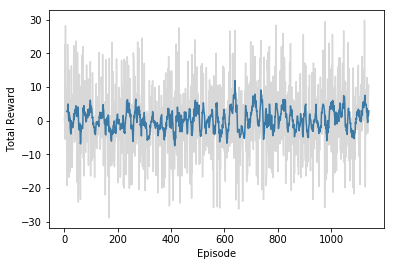

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [17]:
mainQN(Variable(torch.FloatTensor([0,0,1,0.2,0.1,0.1,0.4,0.9])))

tensor([-0.0126,  0.1031,  0.9911], grad_fn=<AddBackward0>)

In [21]:
np.array(rewards_list[1990:2000]).mean()

999.7061111111111

In [22]:
rewards_list[1990:2000]

[(1991, 18.950000000000003),
 (1992, 20.279999999999987),
 (1993, 5.310000000000002),
 (1994, 3.039999999999992),
 (1995, -26.14),
 (1996, 0),
 (1997, 0),
 (1998, 18.269999999999996),
 (1999, 0)]